<a href="https://colab.research.google.com/github/lee-saint/Pixir/blob/master/stage1_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import os
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

TensorFlow 2.x selected.


In [0]:
import sys
sys.path.append('drive/My Drive/Colab Notebooks/pixir/StackGAN')
from stage1_reduce_par_num import *

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 44.4MB/s 


In [0]:
from data import text_preprocessing, bert_encode

In [0]:
data_dir = 'drive/My Drive/Colab Notebooks/pixir/data/birds'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
image_size = 64
batch_size = 64
z_dim = 100
stage1_generator_lr = 0.005
stage1_discriminator_lr = 0.005
stage1_lr_decay_step = 100
epochs = 1000
condition_dim = 128

embeddings_file_path_train = train_dir + '/char-CNN-RNN-embeddings.pickle'
embeddings_file_path_test = test_dir + '/char-CNN-RNN-embeddings.pickle'

filenames_file_path_train = train_dir + '/filenames.pickle'
filenames_file_path_test = test_dir + '/filenames.pickle'

class_info_file_path_train = train_dir + '/class_info.pickle'
class_info_file_path_test = test_dir + '/class_info.pickle'

cub_dataset_dir = data_dir + '/CUB_200_2011'

In [0]:
X_train = np.load('drive/My Drive/Colab Notebooks/pixir/data/birds/X_train.npy')
X_test = np.load('drive/My Drive/Colab Notebooks/pixir/data/birds/X_test.npy')
print(X_train.shape)
print(X_test.shape)

(8855, 64, 64, 3)
(2933, 64, 64, 3)


In [0]:
from tqdm import tqdm

def load_texts_tokens(filenames_file_path, data_dir):
  filenames = load_filenames(filenames_file_path)
  all_tokens = np.empty((len(filenames), 32), dtype='int32')
  all_masks = np.empty((len(filenames), 32), dtype='int32')
  all_segments = np.empty((len(filenames), 32), dtype='int32')
  for i, filename in tqdm(enumerate(filenames)):
    text_path = data_dir + '/text_c10/' + filename + '.txt'
    lines = []
    with open(text_path, mode='r', encoding='utf-8')as f:
      for line in f:
        lines.append(line.replace('\n', ''))
      lines = pd.Series(lines)
    tokens, masks, segments = text_preprocessing(lines)
    random_idx = np.random.choice(len(tokens))
    token, mask, segment = tokens[random_idx], masks[random_idx], segments[random_idx]
    all_tokens[i] = token
    all_masks[i] = mask
    all_segments[i] = segment
  
  return all_tokens, all_masks, all_segments

In [0]:
train_tokens, train_masks, train_segments = load_texts_tokens(filenames_file_path_train, data_dir)
print(train_tokens.shape)
print(train_masks.shape)
print(train_segments.shape)

In [0]:
train_tokens = np.load('drive/My Drive/Colab Notebooks/pixir/StackGAN/train_tokens.npy')
train_masks = np.load('drive/My Drive/Colab Notebooks/pixir/StackGAN/train_masks.npy')
train_segments = np.load('drive/My Drive/Colab Notebooks/pixir/StackGAN/train_segments.npy')

test_tokens = np.load('drive/My Drive/Colab Notebooks/pixir/StackGAN/test_tokens.npy')
test_masks = np.load('drive/My Drive/Colab Notebooks/pixir/StackGAN/test_masks.npy')
test_segments = np.load('drive/My Drive/Colab Notebooks/pixir/StackGAN/test_segments.npy')

print(train_tokens.shape)
print(train_masks.shape)
print(train_segments.shape)

print(test_tokens.shape)
print(test_masks.shape)
print(test_segments.shape)

(8855, 32)
(8855, 32)
(8855, 32)
(2933, 32)
(2933, 32)
(2933, 32)


In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len, ), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_len, ), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_len, ), dtype=tf.int32, name='segment_ids')
    
    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    pooled_output = AveragePooling1D(pool_size=max_len)(sequence_output)
    pooled_output = Flatten()(pooled_output)
    # clf_output = sequence_output[:, 0, :]
    # out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)
    
    return model

In [0]:
%%time
from tensorflow.keras import Model
import tensorflow_hub as hub

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=False)

CPU times: user 19.8 s, sys: 3.54 s, total: 23.3 s
Wall time: 25.6 s


In [0]:
from tensorflow.keras.layers import Dense, Input

bert_model = build_model(bert_layer, max_len=32)
bert_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 32)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 32)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [0]:
%%time
embeddings_train = bert_model.predict([train_tokens, train_masks, train_segments])
print(embeddings_train.shape)

(8855, 1024)
CPU times: user 45.2 s, sys: 28.6 s, total: 1min 13s
Wall time: 1min 13s


In [0]:
%%time
embeddings_test = bert_model.predict([test_tokens, test_masks, test_segments])
print(embeddings_test.shape)

(2933, 1024)
CPU times: user 18.5 s, sys: 9.54 s, total: 28.1 s
Wall time: 31.4 s


In [0]:
np.save('drive/My Drive/Colab Notebooks/pixir/StackGAN/bert_embeddings_train2.npy', embeddings_train)
np.save('drive/My Drive/Colab Notebooks/pixir/StackGAN/bert_embeddings_test2.npy', embeddings_test)

In [0]:
embeddings_train = np.load('drive/My Drive/Colab Notebooks/pixir/StackGAN/bert_embeddings_train.npy')
embeddings_test = np.load('drive/My Drive/Colab Notebooks/pixir/StackGAN/bert_embeddings_test.npy')
print(embeddings_train.shape)
print(embeddings_test.shape)

(8855, 1024)
(2933, 1024)


In [0]:
def load_embedding(filenames_file_path, embeddings_file_path):
  filenames = load_filenames(filenames_file_path)
  all_embeddings = load_embeddings(embeddings_file_path)

  embeddings = []

  # 파일 이름 인덱싱 변경
  for index, filename in enumerate(filenames):
    # print(class_ids[index], filenames[index])
    try:
      all_embeddings1 = all_embeddings[index, :, :]

      embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
      embedding = all_embeddings1[embedding_ix, :]

      embeddings.append(embedding)
    except Exception as e:
      print(e)

  embeddings = np.array(embeddings)

  return embeddings

In [0]:
embeddings_train = load_embedding(filenames_file_path_train, embeddings_file_path_train)
embeddings_test = load_embedding(filenames_file_path_test, embeddings_file_path_test)
print(embeddings_train.shape)
print(embeddings_test.shape)

embeddings: (8855, 10, 1024)
embeddings: (2933, 10, 1024)
(8855, 1024)
(2933, 1024)


In [0]:
gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)
disc_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)

embedding_compressor_model = build_embedding_compressor_model()
embedding_compressor_model.compile(loss='binary_crossentropy', optimizer='adam')

ca_model = build_ca_model()
ca_model.compile(loss='binary_crossentropy', optimizer='adam')

stage1_gen = build_stage1_generator()
stage1_gen.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

stage1_disc = build_stage1_discriminator()
stage1_disc.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=disc_optimizer)

In [0]:
adversarial_model = build_adversarial_model(stage1_gen, stage1_disc)
adversarial_model.compile(loss=[tf.nn.sigmoid_cross_entropy_with_logits, KL_loss],
                          optimizer=gen_optimizer, metrics=None)

In [0]:
adversarial_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 64, 64, 3),  4889600     input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
model_4 (Model)                 (None, 1)            3228801     model_2[1][0]              

In [0]:
stage1_gen.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          262400      input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256)          0           dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128)          0           leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
stage1_disc.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   3072        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  131072      leaky_re_lu_2[0][0]              
____________________________________________________________________________________________

In [0]:
stage1_gen.load_weights('drive/My Drive/Colab Notebooks/pixir/StackGAN/stage1_gen_epoch400.h5')
stage1_disc.load_weights('drive/My Drive/Colab Notebooks/pixir/StackGAN/stage1_disc_epoch400.h5')

In [0]:
tensorboard = TensorBoard(log_dir='drive/My Drive/Colab Notebooks/pixir/StackGAN/logs2/'.format(time.time()))
tensorboard.set_model(stage1_gen)
tensorboard.set_model(stage1_disc)

In [0]:
real_labels = np.ones((batch_size, 1), dtype=np.float32) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype=np.float32) + 0.1

In [0]:
summary_writer = tf.summary.create_file_writer('drive/My Drive/Colab Notebooks/pixir/StackGAN/logs2')

In [0]:
def plot_generated_images(epoch, images, dim=(10, 10), figsize=(10, 10)):
  # images = (images + 1) * 0.5
  plt.figure(figsize=figsize)
  for i in range(dim[0] * dim[1]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(images[i], interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('drive/My Drive/Colab Notebooks/pixir/StackGAN/result_reduce_par_num/epoch_%d.png' % epoch)
  plt.close()

In [0]:
for epoch in range(epochs):
  print('===========================================')
  print('Epoch is:', epoch + 1)
  print('Number of batches:', int(X_train.shape[0] / batch_size))

  gen_losses = []
  disc_losses = []

  number_of_batches = int(X_train.shape[0] / batch_size)
  for index in range(number_of_batches):
    print('Batch: {}'.format(index + 1))

    z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
    image_batch = X_train[index * batch_size:(index + 1) * batch_size]
    embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]

    # 이미지 정규화
    image_batch = image_batch / 127.5 - 1

    fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

    # 진짜 이미지/가짜 이미지/잘못된 이미지로 판별기 훈련
    disc_loss_real = stage1_disc.train_on_batch([image_batch, embedding_batch],
                                                np.reshape(real_labels, (batch_size, 1)))
    disc_loss_fake = stage1_disc.train_on_batch([fake_images, embedding_batch],
                                                np.reshape(fake_labels, (batch_size, 1)))
    disc_loss_wrong = stage1_disc.train_on_batch([image_batch[:(batch_size - 1)], embedding_batch[1:]],
                                                  np.reshape(fake_labels[1:], (batch_size-1, 1)))

    # 생성기 훈련
    g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise],
                                              [np.ones((batch_size, 1)) * 0.9, np.ones((batch_size, 256)) * 0.9])

    # 손실 저장
    d_loss = 0.5 * np.add(disc_loss_real, 0.5 * np.add(disc_loss_wrong, disc_loss_fake))
    print('d_loss:', d_loss)
    print('g_loss:', g_loss)
    disc_losses.append(d_loss)
    gen_losses.append(g_loss[0])

  # 손실값 텐서보드 저장
  with summary_writer.as_default():
    tf.summary.scalar('generator_loss', np.mean(gen_losses), step=epoch)
    tf.summary.scalar('discriminator_loss', np.mean(disc_losses), step=epoch)

  # 10 에포크마다 이미지 생성, 저장
  if epoch == 0 or (epoch + 1) % 10 == 0:
    z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
    embedding_batch = embeddings_test[0:batch_size]
    fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

    plot_generated_images(epoch + 1, fake_images, dim=(8, 8))

  # 100 에포크마다 모델 저장
  if (epoch + 1) % 100 == 0:
    stage1_gen.save_weights(f'drive/My Drive/Colab Notebooks/pixir/StackGAN/par_reduced_stage1_gen_epoch{epoch + 1}.h5')
    stage1_disc.save_weights(f'drive/My Drive/Colab Notebooks/pixir/StackGAN/par_reduced_stage1_disc_epoch{epoch + 1}.h5')
  
  # 100 에포크마다 learning rate 절반으로
  if (epoch + 1) % stage1_lr_decay_step == 0:
    stage1_generator_lr *= 0.5
    stage1_discriminator_lr *= 0.5
    gen_optimizer.learning_rate.assign(stage1_generator_lr)
    disc_optimizer.learning_rate.assign(stage1_discriminator_lr)
    print('learning rate decayed!!')

stage1_gen.save_weights('drive/My Drive/Colab Notebooks/pixir/StackGAN/stage1_gen.h5')
stage1_disc.save_weights('drive/My Drive/Colab Notebooks/pixir/StackGAN/stage1_disc.h5')

d_loss: 0.32509902119636536
g_loss: [0.3543682, 0.33968103, 0.0146871805]
Batch: 101
d_loss: 0.32510560750961304
g_loss: [0.35490194, 0.34168637, 0.013215572]
Batch: 102
d_loss: 0.3251025974750519
g_loss: [0.3736182, 0.35073242, 0.02288577]
Batch: 103
d_loss: 0.3251089006662369
g_loss: [0.37589514, 0.3488534, 0.027041733]
Batch: 104
d_loss: 0.32511138916015625
g_loss: [0.35295534, 0.3373904, 0.015564948]
Batch: 105
d_loss: 0.32510584592819214
g_loss: [0.34551015, 0.33425128, 0.01125887]
Batch: 106
d_loss: 0.3251066952943802
g_loss: [0.3554182, 0.33548927, 0.019928932]
Batch: 107
d_loss: 0.32510508596897125
g_loss: [0.3650366, 0.33916527, 0.025871336]
Batch: 108
d_loss: 0.3251015841960907
g_loss: [0.36170393, 0.34633052, 0.015373409]
Batch: 109
d_loss: 0.32510076463222504
g_loss: [0.3625828, 0.34901237, 0.013570428]
Batch: 110
d_loss: 0.3251042366027832
g_loss: [0.36124578, 0.34203923, 0.019206554]
Batch: 111
d_loss: 0.3251088410615921
g_loss: [0.38437885, 0.34126073, 0.04311812]
Batch:

KeyboardInterrupt: ignored

In [0]:
z_noise3 = np.random.normal(0, 1, size=(16, z_dim))
train_images = stage1_gen.predict_on_batch([embeddings_train[:16], z_noise3])
train_images[0].shape

TensorShape([16, 64, 64, 3])

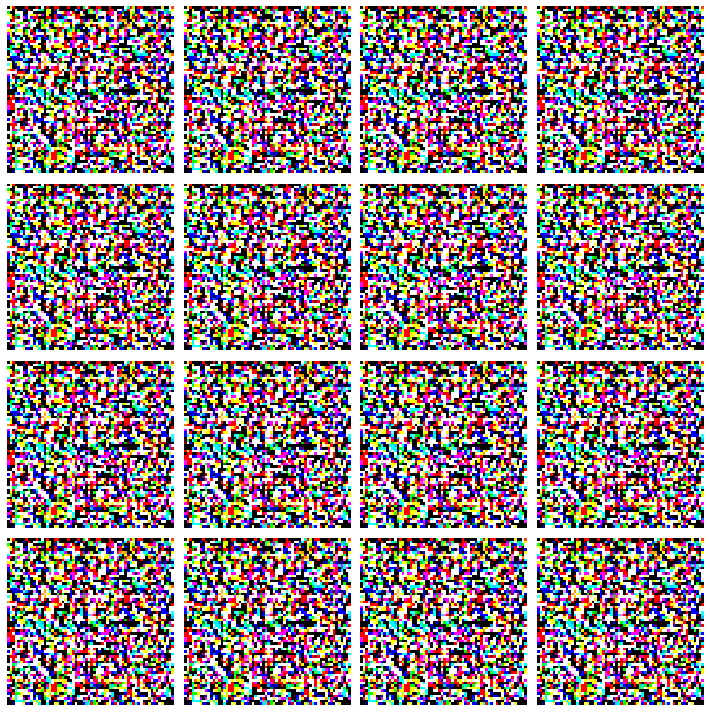

In [0]:
  train_image = (train_images[0] + 1) * 0.5
  plt.figure(figsize=(10, 10))
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_image[i], interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()
  plt.show()